In [1]:
import skimage
import glob
import cv2
import os
import shutil
import skimage
import numpy as np
import pandas as pd

from skimage.io import imread, imsave

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../output/training_df_resize_info.csv')

In [3]:
original_path = '../input/stage1_train'
resized_path = '../output/stage1_train_resized'

In [4]:
def mkdir_p(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_image_or_mask(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    # for mask: color_mode=cv2.IMREAD_GRAYSCALE
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img


In [5]:
train_paths = glob.glob(original_path + '/*')
train_paths.sort()
mkdir_p(resized_path)
len(train_paths)

670

In [6]:
counter = 0
for path in train_paths:
    counter += 1
    if counter % 100 == 0:
        print(counter)
    image_id = path.split('/')[-1]
    mkdir_p(resized_path + os.sep + image_id)
    mkdir_p(resized_path + os.sep + image_id + '/images')
    mkdir_p(resized_path + os.sep + image_id + '/masks')
    
    # resize image
    image_path = path + '/images/' + image_id + '.png'
    query = df.loc[df['ImageId'] == image_id]
    resize_h = query['ResizeH']
    resize_w = query['ResizeW']
    image = read_image_or_mask(image_path, target_size=(resize_h, resize_w))
    
    resize_image_path = resized_path + os.sep + image_id + '/images/' + image_id + '.png'
    cv2.imwrite(resize_image_path, image)
    
    # resize masks
    mask_paths = glob.glob(path + '/masks/*.png')
    for filepath in mask_paths:
        mask = read_image_or_mask(filepath, color_mode=cv2.IMREAD_GRAYSCALE, target_size=(resize_h, resize_w))
        resize_mask_path = resized_path + os.sep + image_id + '/masks/' + (filepath.split('/')[-1])
        cv2.imwrite(resize_mask_path, mask)  

100
200
300
400
500
600


### split

In [7]:
random_state = 1234
df.sample(frac=1.0, random_state=random_state)

df['Type'].value_counts()

1    546
0    108
2     16
Name: Type, dtype: int64

In [8]:
df_0 = df[df['Type'] == 0]
df_1 = df[df['Type'] == 1]
df_2 = df[df['Type'] == 2]

In [9]:
split_path = '../output/split'
mkdir_p(split_path)

In [10]:
train_gray = open(split_path + os.sep + 'train3_ids_gray_500', 'w')
val_gray = open(split_path + os.sep + 'val3_ids_gray_46', 'w')
train_counter = 0
val_counter = 0
for i in range(len(df_1)):
    image_id = df_1.iloc[i]['ImageId']
    if i < 500:
        train_gray.write('stage1_train_resized/' + image_id + '\n')
        train_counter += 1
    elif i >= 500:
        val_gray.write('stage1_train_resized/' + image_id + '\n')
        val_counter += 1

train_gray.close() 
val_gray.close() 

assert(train_counter == 500)
assert(val_counter == 46)

In [11]:
train_color = open(split_path + os.sep + 'train3_ids_color_100', 'w')
val_color = open(split_path + os.sep + 'val3_ids_color_8', 'w')
train_counter = 0
val_counter = 0
for i in range(len(df_0)):
    image_id = df_1.iloc[i]['ImageId']
    if i < 100:
        train_color.write('stage1_train_resized/' + image_id + '\n')
        train_counter += 1
    elif i >= 100:
        val_color.write('stage1_train_resized/' + image_id + '\n')
        val_counter += 1

train_color.close() 
val_color.close()

assert(train_counter == 100)
assert(val_counter == 8)

In [12]:
train_670 = open(split_path + os.sep + 'train3_ids_all_670', 'w')
train_counter = 0
for i in range(len(df)):
    image_id = df.iloc[i]['ImageId']
    train_670.write('stage1_train_resized/' + image_id + '\n')
    train_counter += 1

train_670.close() 

assert(train_counter == 670)


In [13]:
np.min(df['ResizeH']), np.min(df['ResizeW'])

(128, 128)

In [14]:
np.min(df['ShapeH']), np.min(df['ShapeW'])

(256, 256)

### other way to resize mask

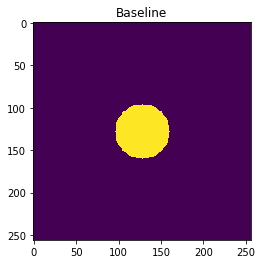

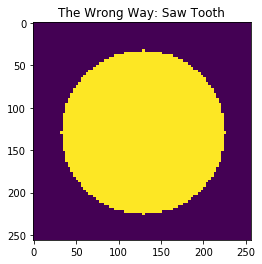

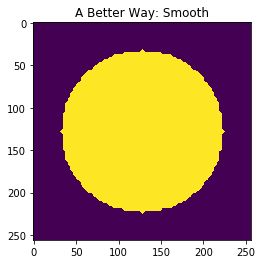

Done!


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

base_img = np.zeros((256,256),dtype=np.uint8)

base_img = cv2.circle(base_img,center=(128,128), 
                 radius=32, 
                 color=255, 
                 thickness=-1)

plt.title("Baseline")
plt.imshow(base_img)
plt.show()

# resize using cv2.resize
imgx3 = cv2.resize(base_img, (256*3,256*3),interpolation=cv2.INTER_NEAREST)
imgx3 = imgx3[256:512,256:512]

plt.title("The Wrong Way: Saw Tooth")
plt.imshow(imgx3)
plt.show()

# resize using cv2 contours

# extract the contours
_, cnts_base, hierarchy = cv2.findContours(base_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# create a new (empty) image
imgx3 = np.zeros((256,256),dtype=np.uint8)

# loop through the contours
new_cnts = []
for c in cnts_base:
  # multiply them by 3, keeping 128,128 as the centre
  c = (c - 128) * 3 + 128
  new_cnts.append(c)

cnts_base = new_cnts

# draw the contours onto the empty image
cv2.drawContours(imgx3,cnts_base,-1,255,-1)

plt.title("A Better Way: Smooth")
plt.imshow(imgx3)
plt.show()

print("Done!")

In [16]:
np.unique(base_img, return_counts=True)

(array([  0, 255], dtype=uint8), array([62327,  3209]))

In [17]:
3209*9

28881

In [18]:
np.unique(imgx3, return_counts=True)

(array([  0, 255], dtype=uint8), array([37203, 28333]))

In [19]:
imgx3 = cv2.resize(base_img, (256*3,256*3),interpolation=cv2.INTER_NEAREST)
imgx3 = imgx3[256:512,256:512]

np.unique(imgx3, return_counts=True)

(array([  0, 255], dtype=uint8), array([36655, 28881]))